In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
!ls /g/data/ua8/LE_models/20CRv3/mean_daily/prmsl

prmsl.1836.nc  prmsl.1872.nc  prmsl.1908.nc  prmsl.1944.nc  prmsl.1980.nc
prmsl.1837.nc  prmsl.1873.nc  prmsl.1909.nc  prmsl.1945.nc  prmsl.1981.nc
prmsl.1838.nc  prmsl.1874.nc  prmsl.1910.nc  prmsl.1946.nc  prmsl.1982.nc
prmsl.1839.nc  prmsl.1875.nc  prmsl.1911.nc  prmsl.1947.nc  prmsl.1983.nc
prmsl.1840.nc  prmsl.1876.nc  prmsl.1912.nc  prmsl.1948.nc  prmsl.1984.nc
prmsl.1841.nc  prmsl.1877.nc  prmsl.1913.nc  prmsl.1949.nc  prmsl.1985.nc
prmsl.1842.nc  prmsl.1878.nc  prmsl.1914.nc  prmsl.1950.nc  prmsl.1986.nc
prmsl.1843.nc  prmsl.1879.nc  prmsl.1915.nc  prmsl.1951.nc  prmsl.1987.nc
prmsl.1844.nc  prmsl.1880.nc  prmsl.1916.nc  prmsl.1952.nc  prmsl.1988.nc
prmsl.1845.nc  prmsl.1881.nc  prmsl.1917.nc  prmsl.1953.nc  prmsl.1989.nc
prmsl.1846.nc  prmsl.1882.nc  prmsl.1918.nc  prmsl.1954.nc  prmsl.1990.nc
prmsl.1847.nc  prmsl.1883.nc  prmsl.1919.nc  prmsl.1955.nc  prmsl.1991.nc
prmsl.1848.nc  prmsl.1884.nc  prmsl.1920.nc  prmsl.1956.nc  prmsl.1992.nc
prmsl.1849.nc  prmsl.1885.nc  prmsl.19

In [4]:
path_p = '/g/data/ua8/LE_models/20CRv3/mean_daily/prmsl/*.nc'

In [17]:
# read in daily mean sea level pressure (mean across all 20CR members)
P_ds = xr.open_mfdataset(path_p)
del P_ds['time_bnds']
P_ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 65744)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1836-01-01 1836-01-02 ... 2015-12-31
Data variables:
    prmsl    (time, lat, lon) float32 dask.array<chunksize=(366, 181, 360), meta=np.ndarray>
Attributes: (12/24)
    Conventions:               CF-1.2
    title:                     mean Daily NOAA/CIRES/DOE 20th Century Reanaly...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    spatial_resolution:        1.0 degree
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...

In [33]:
# resample to monthly
P_mon = P_ds.resample(time='M').min(dim='time')
P_mon

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    prmsl    (time, lat, lon) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [46]:
with dask.diagnostics.ProgressBar():
    P_mon.to_netcdf('MSLP_mon.nc')

[########################################] | 100% Completed |  2min 19.2s


P*40�S and P*65�S are the normalized monthly zonal sea level pressure (SLP) at 40�S and 65�S
The 30-year period from 1971-2000 is used for the normalization period. Note that this period is arbitrary and a switch to a different period would change the exact SAM values but would be unlikely to significantly alter any trends.
(true zonal mean was simply the mean of the 144 points along the appropriate parallel)

# need to normalise P40 and should probs save PRMSL monthly as a netcdf and also maybe SAM

In [25]:
# read in netcdf of monthly pressure
P_mon_ds = xr.open_dataset('MSLP_mon.nc')

In [72]:
# calculate the zonal mean mslp at 40 and 65S (to be used in calculating SAM)
P40S = P_mon_ds.sel(lat=-40).mean(dim='lon')
P65S = P_mon_ds.sel(lat=-65).mean(dim='lon')
P65S

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    lat      float32 -65.0
Data variables:
    prmsl    (time) float32 9.88e+04 9.872e+04 9.846e+04 ... 9.592e+04 9.68e+04

In [27]:
# set the dates for the normalisation period
start_date = '1971'
end_date = '2000'

In [76]:
# calculate the normalised zonal mean, x, (x-mean)/std
anom40 = func.monthly_anomaly(P40S, start_date, end_date)
anom65 = func.monthly_anomaly(P65S, start_date, end_date)
anom65

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    lat      float32 -65.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prmsl    (time) float32 1.437e+03 1.797e+03 1.856e+03 ... -868.9 -471.2

In [77]:
std40 = anom40.sel(time=slice(start_date, end_date)).std(dim='time')
std65 = anom65.sel(time=slice(start_date, end_date)).std(dim='time')
std40

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 -40.0
Data variables:
    prmsl    float64 178.9

In [79]:
# normalise the pressure values by minusing the mean (ie calculating anomaly) and dividing by 30-year average
P40S_n = anom40/std40
P65S_n = anom65/std65

In [73]:
# normalise the pressure values by dividing by 30-year average
norm40 = P40S.sel(time=slice(start_date, end_date)).std(dim='time')
P40S_n = P40S/norm40

norm65 = P65S.sel(time=slice(start_date, end_date)).std(dim='time')
P65S_n = P65S/norm65
print(norm65.prmsl.data, norm40.prmsl.data)

504.2710876464844 300.1958923339844


In [80]:
# calculate the SAM index by finding the normalised pressure difference between the two latitude bands
SAM = P40S_n - P65S_n
SAM

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prmsl    (time) float64 1.701 0.5813 1.714 2.078 ... -0.6553 1.869 0.5343

In [55]:
e_date = ['1883-08-27']

<AxesSubplot:ylabel='prmsl'>

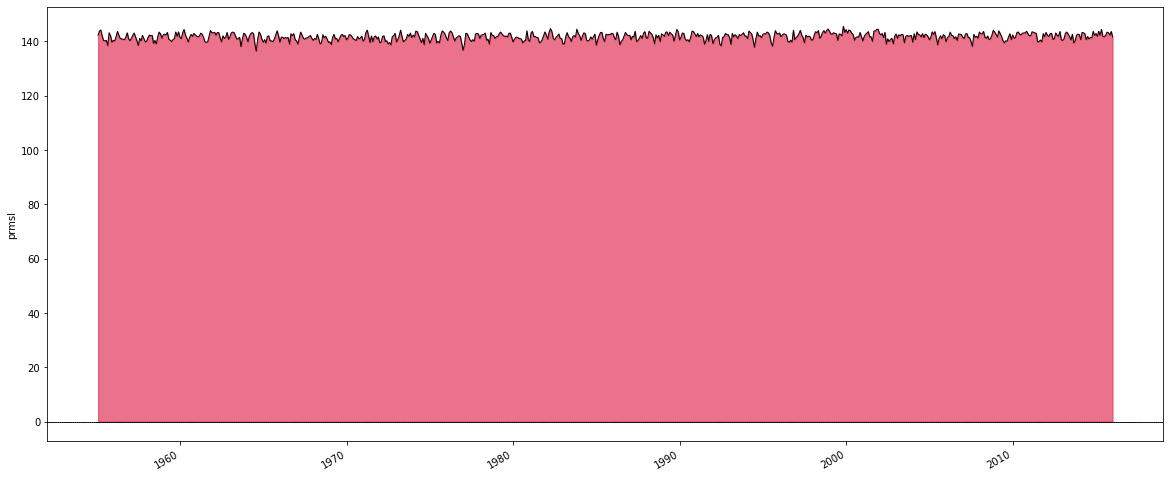

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
SAM_plot(SAM.prmsl.sel(time=slice('1955','2015')), ax = axes)

In [106]:
ds.time.data[-1]

numpy.datetime64('1900-12-31T00:00:00.000000000')

# figures

In [137]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Negative SAM: westerly winds further north than usual.  This brings more precipitation to southwest and southeast in winter and less precipitation in parts of the east, so it is likely to be wetter in Victoria, but dry in New South Wales. There is also an increased chance of snow in alpine areas.  In summer, a negative SAM causes a decreased likelihood of precipitation in the southeast and east and a greater chance of spring heatwaves in sourthern australia.  Th
In EL Ninos SAM tends to be more negative particularly in spring and summer. This enhances El Nino signals.    

(citation: http://www.bom.gov.au/climate/sam/#tabs=What-is-SAM%3F) 

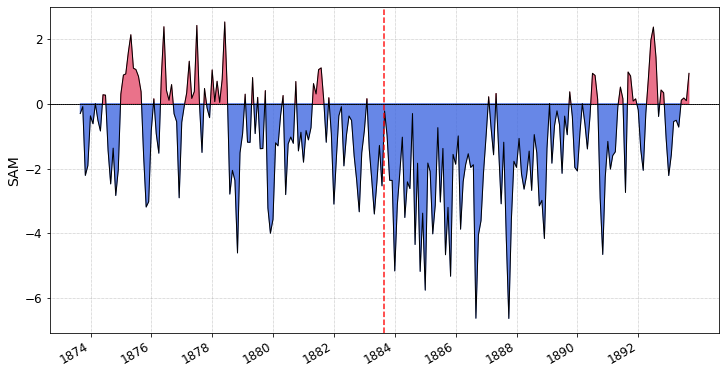

In [144]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
start_date, end_date = '1873-08','1893-08'
ds = SAM.prmsl.sel(time=slice(start_date, end_date))
SAM_plot(ds, ax = axes, e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='2YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

plt.savefig('R_K_timeseries_mon_SAM.png', dpi=300, bbox_inches='tight')

[Text(-43829.0, 0, '1850'),
 Text(-42003.0, 0, '1855'),
 Text(-40177.0, 0, '1860'),
 Text(-38350.0, 0, '1865'),
 Text(-36524.0, 0, '1870'),
 Text(-34698.0, 0, '1875'),
 Text(-32872.0, 0, '1880'),
 Text(-31045.0, 0, '1885'),
 Text(-29219.0, 0, '1890'),
 Text(-27393.0, 0, '1895'),
 Text(-25567.0, 0, '1900')]

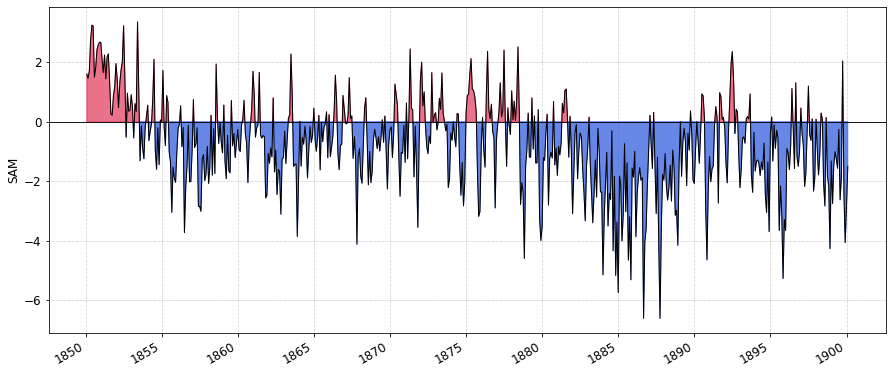

In [135]:
fig, axes = plt.subplots(1, 1, figsize=(15,6))
start_date, end_date = '1850-01','1900-01'
ds = SAM.prmsl.sel(time=slice(start_date, end_date))
SAM_plot(ds, ax = axes)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='5YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

[Text(-5479.0, 0, '1955'),
 Text(-3653.0, 0, '1960'),
 Text(-1826.0, 0, '1965'),
 Text(0.0, 0, '1970'),
 Text(1826.0, 0, '1975'),
 Text(3652.0, 0, '1980'),
 Text(5479.0, 0, '1985'),
 Text(7305.0, 0, '1990'),
 Text(9131.0, 0, '1995'),
 Text(10957.0, 0, '2000'),
 Text(12784.0, 0, '2005'),
 Text(14610.0, 0, '2010'),
 Text(16436.0, 0, '2015')]

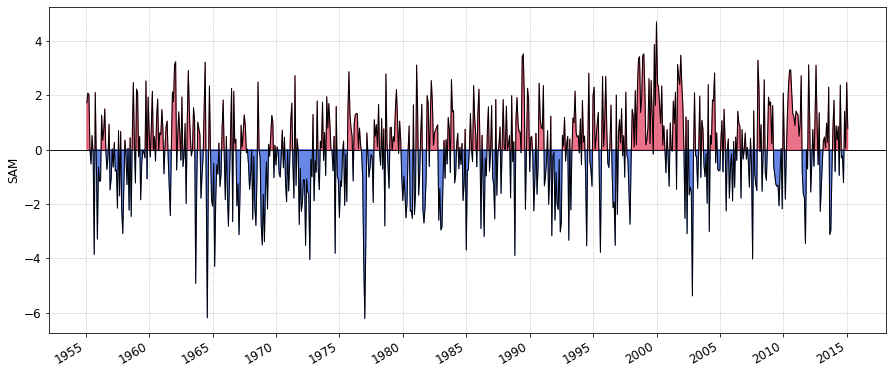

In [136]:
fig, axes = plt.subplots(1, 1, figsize=(15,6))
start_date, end_date = '1955-01','2015-01'

ds = SAM.prmsl.sel(time=slice(start_date, end_date))
SAM_plot(ds, ax = axes)

#set the frequency of the xticks 
#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='5YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

In [122]:
def SAM_plot(ds, e_date=None, ax=None, **kwargs):
    
    import matplotlib.pyplot as plt, numpy as np, pandas as pd
    
    if ax is None:
        ax = plt.gca()
        
    # plot data and fill if it's over the thresholds
    ds.plot(color='k', lw=1)
    ax.fill_between(ds.time.values, ds.values, 0, where=ds.values>0, interpolate =True, color='crimson', alpha=0.6)
    ax.fill_between(ds.time.values, ds.values, 0, where=ds.values<0, interpolate =True, color='royalblue', alpha=0.8)
    ax.axhline(0, color='k', lw=0.8)
    ax.axhline(0, color='k', lw=0.8, linestyle = ':')
    ax.axhline(0, color='k', lw=0.8, linestyle = ':')

#     # plot gridlines
    ax.grid(which='major', ls=':', lw='0.5', color='grey') # customise major grid
#     ax.minorticks_on() # need this line in order to get the minor grid lines 
#     ax.grid(which='minor', ls=':', lw='0.5', color='grey')
    ax.set_axisbelow(True) # sets the gridlines behind the data

#     #set the frequency of the xticks 
#     years = pd.date_range(ds.time.data[0], ds.time.data[-1], freq='YS')
#     ax.set_xticks(years.values)
#     ax.set_xticklabels(years.year) # .year shows only the year (not month)

    # remove xlabels and set ylabel
    ax.set_xlabel(None)
    ax.set_title(None)
    ax.set_ylabel(f'SAM')

    # add dotted lineshowing the year of the krakatoa eruption
    if e_date is not None:
        ax.axvline(x=e_date[0], color = 'red', linestyle = '--', alpha = 0.9, linewidth='1.5')
    
    return ax

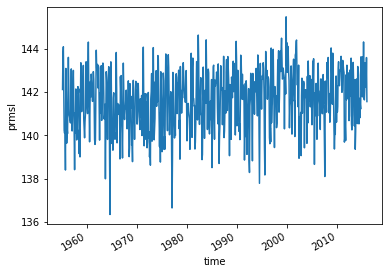

In [71]:
with dask.diagnostics.ProgressBar():
    (SAM).sel(time=slice('1955','2015')).prmsl.plot()